In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs
import pickle

In [2]:
np.random.seed(6)

# Initialize RNN

In [3]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [4]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
cache_state = 50

In [6]:
cache_unit = (cache_state/num_states)*N_inp

# Influencing recall via adjustment of predictive component

In [7]:
model = Model(
    N_inp, N_bar, num_states,
    narrow_search_factor=0.5, wide_search_factor=1.5,
    )
unskewed_J = model.J_xx.copy()

### Add predictive skew to RNN weights

In [8]:
recalc_pred_delta = False

# Last choice: 300 shifts, 0.99 gamma, delta scale 0.05, offset 0.01

if recalc_pred_delta:
    identity = np.eye(model.N_bar)
    total_delta = np.zeros((model.N_bar, model.N_bar))
    n_shifts = 300 #500 
    gamma = 0.99
    for s in range(1, n_shifts):
        shifted = np.roll(identity, shift=-(s+1), axis=0)
        delta = 0.05 * (gamma**s)*shifted
        total_delta += delta
    total_delta -= 0.01
    with open('pickles/fig6_pred_matrix.p', 'wb') as f:
        pickle.dump(total_delta, f)
else:
    with open('pickles/fig6_pred_matrix.p', 'rb') as f:
        total_delta = pickle.load(f)

In [9]:
w1 = 1.
w2 = 1.5
model.J_xx = (w1)*unskewed_J.copy() + (w2)*total_delta

### Learning with skew

In [10]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
    
print("Now I just cached at location:", cache_state)
preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

# 0 seed input
_, _, outputs, _ = model.run_recall(0., place_inputs)
_pred_readout = outputs[1].squeeze()
_pred_readout = _pred_readout/_pred_readout.max()
pred_readout = _pred_readout.copy()

Now I just cached at location: 50


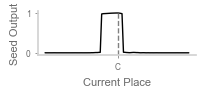

In [15]:
plt.figure(figsize=(2.1,1.))
plt.plot(_pred_readout, color='black')
plt.xticks([cache_state], ['C'], fontsize=6)
plt.ylabel('Seed Output')
plt.xlabel('Current Place')
plt.yticks([0,1], fontsize=6)
plt.axvline(cache_state, color='gray', linestyle='--')
plt.tight_layout()
plt.savefig('figures/fig6g.svg', dpi=300, transparent=True)
plt.show()